Setting up environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Importing necessary libraries
import tensorflow as tf # tensorflow 2.x
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Activation, Dropout, Lambda, Conv2DTranspose, AveragePooling2D, GaussianNoise
from keras.models import Model
from keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils.class_weight import compute_class_weight
from matplotlib import pyplot as plt
import matplotlib
import time
import numpy as np
from scipy import stats
from keras import metrics
import random
import math
import pandas as pd
import statistics
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.regularizers import l2, l1
from scipy.signal.windows import gaussian

!pip install hic-straw
import hicstraw

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.13.4-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.4-py3-none-any.whl (240 kB)
  Created wheel for hic-straw: filename=hic_straw-1.3.1-cp310-cp310-linux_x86_64.whl size=1616772 sha256=e1e60efd00cfde1c05181ce47b1cdc732beea97e597b6c13d7627b42ef041b52
  Stored in directory: /root/.cache/pip/wheels/23/85/e0/14f1be833ddf1da34165e04938653e00b602eb93e834497ae4
Successfully built hic-straw


In [3]:
# Loading testing files

!wget https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic

files = ['HIC1024_deep.hic']

--2024-08-19 23:07:38--  https://www.dropbox.com/sh/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic [following]
--2024-08-19 23:07:38--  https://www.dropbox.com/sh/raw/3eh3lbzedwc0hrg/AABHmvN7KxvYvaQgbNwKceFha/HIC1024_deep.hic
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0f5e869d1d74e7cf7f4d01aea5.dl.dropboxusercontent.com/cd/0/inline/CY-C71_Ua8cqRXaqOBmvrTVcnv7b17FktGlxNIQ0Rf8Prs7RGiErsCtZWNF7RcFCcL8zhc6WeI7b3CBMIOiza_nHRA2MZdLzFt6LLlGaIANITMD1pi1tRQYXuFDHhXnB0iUMZWyg_5mtkv0xE0NwWyj6/file# [following]
--2024-08-19 23:07:39--  https://uc0f5e869d1d74e7cf7f4d01aea5.dl.dropboxusercontent.com/cd/0/inline/CY-C71_Ua

In [4]:
# Setting up global variables
WIDTH=40 # Size of input matrix
res=50000 # resolution
br = matplotlib.colors.LinearSegmentedColormap.from_list("bright_red",[(1,1,1),(1,0,0)]) # color scheme
np.set_printoptions(suppress = True)
labels = ['0_to_0.25MB', '0.25_to_0.5MB', '0.5_to_1MB', '1_to_2MB', '2_to_5MB',
        '5_to_10MB', '10_to_20MB', '20+MB', 'Interchromosomal']
model = tf.keras.models.load_model("DistanceClassifier.h5")

Preprocessing and helper functions

In [15]:
# Performing Gaussian blurring on an image

def gaussian_kernel(kernel_size, std):
    gk1d = gaussian(kernel_size, std).reshape(kernel_size, 1)
    gk2d = np.outer(gk1d, gk1d)
    return gk2d/gk2d.sum()

kernel_size = 5
std_dev = 1.0
gauss_kernel = gaussian_kernel(kernel_size, std_dev)

def blur(image_matrix, gauss_kernel, kernel_size):
  image_tensor = tf.reshape(image_matrix, [1, *image_matrix.shape, 1])
  gauss_kernel_tensor = tf.convert_to_tensor(gauss_kernel, dtype=image_tensor.dtype)
  gauss_kernel_tensor = tf.reshape(gauss_kernel_tensor, [kernel_size, kernel_size, 1, 1])
  blurred_image = tf.nn.conv2d(image_tensor, gauss_kernel_tensor, strides=[1, 1, 1, 1], padding="SAME")
  return blurred_image.numpy().squeeze()

# Populating the sub, sub-sub, super, super-super, and regular diagonal with 0s

def clear_diagonal(array):
  WIDTH = array.shape[1]
  diagonal_indices = np.arange(WIDTH)

  array[:, diagonal_indices, diagonal_indices, :] = 0
  array[:, diagonal_indices[1:], diagonal_indices[:-1], :] = 0
  array[:, diagonal_indices[:-1], diagonal_indices[1:], :] = 0
  array[:, diagonal_indices[2:], diagonal_indices[:-2], :] = 0
  array[:, diagonal_indices[:-2], diagonal_indices[2:], :] = 0
  return array

In [5]:
# OE functions

# Averages out each diagonal
# For symmetric matrices, return an array with the values on each diagonal replaced by the average of that diagonal
def replace_diagonal_with_average(arr):
  max_offset = arr.shape[0]
  for i in range(1, max_offset):
    np.fill_diagonal(arr[:i, max_offset-i:], np.mean(np.diagonal(arr, offset=max_offset-i)))
    np.fill_diagonal(arr[max_offset-i:, :i], np.mean(np.diagonal(arr, offset=i-max_offset)))
  np.fill_diagonal(arr, np.mean(np.diagonal(arr)))

  return arr

# Return a WIDTH * WIDTH array of a near-diagonal expected matrix

def get_expected_matrix(hic, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  expected_matrix = np.zeros([WIDTH, WIDTH])
  expected_matrices = np.zeros([sample_size, WIDTH, WIDTH])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1
  for i in range(sample_size): # Sample of matrices taken
    scaffold = int(random.random()*num_chroms)+1 # Choosing random chromosome
    chr1_start = int(random.random()*(chroms[scaffold].length//res-(WIDTH-1))) * res # Choosing random start point
    matrix = hic.getMatrixZoomData(chroms[scaffold].name, chroms[scaffold].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)
    expected_matrices[i, :, :] = replace_diagonal_with_average(matrix) # Creating expected matrix


  for i in range(WIDTH):
    for j in range(WIDTH):
      expected_matrix[i, j] = np.median(expected_matrices[:, i, j]) # Taking median of expected matrices to prevent skew from abnormal examples

  return expected_matrix

In [6]:
# Centile Rescaling

# Capping the matrix at a certain threshold and then linearly scaling between 0 and 1

def globalPercentileProcess(matrix, threshold):
  return np.where(matrix<threshold, matrix, threshold)/threshold

# Determine numerical value for centile
# Done very similarly to get_expected_matrix function above

def get_med_threshold(hic, centiles, res, WIDTH, sample_size = 20, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  thresholds=np.zeros([len(centiles), sample_size])
  chroms = hic.getChromosomes()
  num_chroms = len(chroms)-1

  for i in range(sample_size):
    chrom = int(random.random()*num_chroms)+1
    chr1_start = int(random.random()*(chroms[chrom].length//res-(WIDTH-1)))
    matrix = hic.getMatrixZoomData(chroms[chrom].name, chroms[chrom].name, data_type, normalization, unit, res)
    matrix = matrix.getRecordsAsMatrix(chr1_start, chr1_start+(WIDTH-1)*res, chr1_start, chr1_start+(WIDTH-1)*res)

    for idx, centile in enumerate(centiles):
      thresholds[idx, i] = np.percentile(matrix, centile) # Centile threshold calculated for each matrix

  final_thresholds = list()
  for i in range(len(centiles)):
    final_thresholds.append(statistics.median(thresholds[i]))

  return final_thresholds

In [9]:
# Helper functions used in data creation
# size = WIDTH
# partp is the partition point where the first region ends and the second region begins
# partp = len(region1) = size - len(region2)

# Stitching a matrix together given the first region, second region, and common region

def construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb):
  matrix = np.zeros([size, size])

  matrix[0:partp, 0:partp] = matrix_chr1
  matrix[partp:size, partp:size] = matrix_chr2

  common = matrix_comb

  matrix[0:partp, partp:size] = common
  matrix[partp:size, 0:partp] = np.flipud(np.rot90(common))

  return matrix

# Downsamples a matrix the same way Juicebox does
def hic_downsample(size, ds_scale, matrix):

  smatrix = np.zeros([int(size/ds_scale), int(size/ds_scale)])

  for i in range(int(size/ds_scale)):
    for j in range(int(size/ds_scale)):
      if i==j:
        smatrix[i, j] = np.sum(np.triu(matrix[ds_scale*i:ds_scale*(i+1), ds_scale*j:ds_scale*(j+1)]))
      else:
        smatrix[i, j] = np.sum(matrix[ds_scale*i:ds_scale*(i+1), ds_scale*j:ds_scale*(j+1)])

  return smatrix

# Determines the expected matrix and downsamples it
# observed/oe = observed / (observed/expected) = expected
def hic_expected_downsample(size, ds_scale, matrix_observed, matrix_oe):
  matrix = matrix_observed/matrix_oe
  return hic_downsample(size, ds_scale, matrix)

# Grabbing the first, second, and common chromosome regions given the start point of each region and the partition point (which gives the length of each region)
# chrom1 and chrom2 are indexes, not chromosome names
def grabFromStraw(hic, res, chrom1, chrom2, chr1_start, chr2_start, partp, size, data_type = 'observed', normalization = 'NONE', unit = 'BP'):
  chroms = hic.getChromosomes()

  matrix_chr1 = hic.getMatrixZoomData(chroms[chrom1].name, chroms[chrom1].name, data_type, normalization, unit, res)
  matrix_chr1 = matrix_chr1.getRecordsAsMatrix(chr1_start, chr1_start+(partp-1)*res, chr1_start, chr1_start+(partp-1)*res)

  matrix_chr2 = hic.getMatrixZoomData(chroms[chrom2].name, chroms[chrom2].name, data_type, normalization, unit, res)
  matrix_chr2 = matrix_chr2.getRecordsAsMatrix(chr2_start, chr2_start+(size-1-partp)*res, chr2_start, chr2_start+(size-1-partp)*res)

  matrix_comb = hic.getMatrixZoomData(chroms[chrom1].name, chroms[chrom2].name, data_type, normalization, unit, res)
  matrix_comb = matrix_comb.getRecordsAsMatrix(chr1_start, chr1_start+(partp-1)*res, chr2_start, chr2_start+(size-1-partp)*res)

  return matrix_chr1, matrix_chr2, matrix_comb

# Another downsampling method which assigns the average of all the points in a block to the corresponding bin in the downsampled matrix
# Doesn't make much sense to use for hic data, would not recommend
def average(size, ds_scale, matrix):

  smatrix = np.zeros([int(size/ds_scale), int(size/ds_scale)])

  for i in range(int(size/ds_scale)):
    for j in range(int(size/ds_scale)):
      smatrix[i, j] = np.mean(matrix[ds_scale*i:ds_scale*(i+1), ds_scale*j:ds_scale*(j+1)])

  return smatrix

Creating examples with interchromosomal and intrachromosomal breaks

In [10]:
# Creates interchromsomal breaks
def data_interchromosomal(hic, size=100, res = 100000, ds_scale=10):

  size *= ds_scale # Creating larger matrix to downsample later

  # If res is not a multiple of ds_scale downsampling won't work properly
  if not res%ds_scale == 0:
    print("ds_scale should be a divsor of res")
    return

  res //= ds_scale # Creating at lower resolution to downsample later

  chroms = hic.getChromosomes()
  partp = size//2 - int(random.random()*ds_scale) # Partition point should be in the last bin of the first half of the downsampled matrix (e.g. 5th bin in 10 by 10 matrix)
  chrom1 = int(random.random()*(len(chroms)-1))+1 # Selecting a chromosome by getting its index in chroms
  # Selecting 0 as an index is invalid because chroms[0] is All

  # Selecting a second, different chromosome
  chrom2 = chrom1
  while(chrom2==chrom1):
    chrom2 = int(random.random()*(len(chroms)-1))+1

  # Checking if both chromosomes are larger than the regions that will be drawn from them
  if (chroms[chrom1].length<res*partp or chroms[chrom2].length<(size-partp)*res):
    # Rerunning the function if the answer is no
    return data_interchromosomal(hic, size//ds_scale, res*ds_scale, ds_scale)

  # Getting a random start location (at a multiple of res) so the full region will fit in between the start location and end of the chromosome
  chr1_start = int(random.random()*(chroms[chrom1].length//res-partp+1))*res
  chr2_start = int(random.random()*(chroms[chrom2].length//res-size+1+partp))*res

  # Grabbing and constructing observed matrix
  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chrom1, chrom2, chr1_start, chr2_start, partp, size, 'observed', 'NONE', 'BP')
  matrix = construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb)

  # Grabbing and constructing oe matrix
  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chrom1, chrom2, chr1_start, chr2_start, partp, size, 'oe', 'NONE', 'BP')
  matrix2 = construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb)

  # Downsampling
  observed_matrix = hic_downsample(size, ds_scale, matrix)
  expected_matrix = hic_expected_downsample(size, ds_scale, matrix, matrix2)

  # np.inf is the distance between two regions on different chromosomes
  return observed_matrix, observed_matrix/expected_matrix, np.inf

In [11]:
# Creates an intrachromosomal break with two regions a specified distance apart
def data_specific_distance_intrachromosomal(hic, size=100, res = 100000, ds_scale=10, distance=0):

  size *= ds_scale
  if not res%ds_scale == 0:
    print("ds_scale should be a divsor of res")
    return
  res //= ds_scale

  chroms = hic.getChromosomes()
  partp = size//2 - int(random.random()*ds_scale)
  chrom = int(random.random()*(len(chroms)-1))+1

  # Checks to see if chromosome is large enough to create example
  if chroms[chrom].length<res*partp+distance:
    return data_specific_distance_intrachromosomal(hic, size//ds_scale, res*ds_scale, ds_scale, distance)

  chr_start = int(random.random()*(chroms[chrom].length//res-size-distance//res)) * res
  chr_continue = chr_start + distance + partp*res

  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chrom, chrom, chr_start, chr_continue, partp, size, 'observed', 'NONE', 'BP')
  matrix = construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb)

  matrix_chr1, matrix_chr2, matrix_comb = grabFromStraw(hic, res, chrom, chrom, chr_start, chr_continue, partp, size, 'oe', 'NONE', 'BP')
  matrix2 = construct_matrix(size, partp, matrix_chr1, matrix_chr2, matrix_comb)

  observed_matrix = hic_downsample(size, ds_scale, matrix)
  expected_matrix = hic_expected_downsample(size, ds_scale, matrix, matrix2)

  return observed_matrix, observed_matrix/expected_matrix, distance

Distance vs. Probability

In [21]:
distances = list(range(101)) # Range of distances
predictions = np.zeros([101, 10, len(labels)])
c = 1000*1000 # constant value to multiply with
hic = hicstraw.HiCFile(files[0])
expected_matrix = get_expected_matrix(hic, res, WIDTH) # Manually creating expected matrix
thresholds = get_med_threshold(hic, [95, 90, 80], res, WIDTH)

for distance in distances:
  for j in range(10):
    observed, _, __ = data_specific_distance_intrachromosomal(hic = hic, size = WIDTH, res = res, ds_scale=10, distance=distance*c) # Generating example at a particular distance
    input_matrix = np.zeros([1, WIDTH, WIDTH, 9])
    input_matrix[0, :, :, 0] = globalPercentileProcess(observed, thresholds[0]) # Preprocessing
    input_matrix[0, :, :, 1] = globalPercentileProcess(observed, thresholds[1])
    input_matrix[0, :, :, 2] = globalPercentileProcess(observed, thresholds[2])
    input_matrix[:, :, :, 3:6] = input_matrix[:, :, :, :3]
    clear_diagonal(input_matrix[:, :, :, 3:6]) # Clearing the middle diagonal of the matrix
    input_matrix[:, :, :, 6:] = blur(input_matrix[:, :, :, :3], gauss_kernel, kernel_size) # Blurring the matrix
    predictions[distance, j] = model.predict(input_matrix) # Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


<ipython-input-9-a19cc802ad99>:38: RuntimeWarning: invalid value encountered in divide
  matrix = matrix_observed/matrix_oe


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

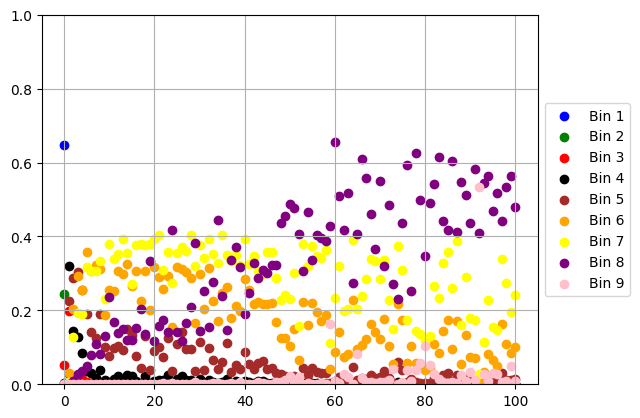

In [22]:
# Plotting median prediction from each output bin in the model for each distance

medians = np.median(predictions, axis=1)

plt.scatter(distances, medians[:, 0], color='blue', label='Bin 1')
plt.scatter(distances, medians[:, 1], color='green', label='Bin 2')
plt.scatter(distances, medians[:, 2], color='red', label='Bin 3')
plt.scatter(distances, medians[:, 3], color='black', label='Bin 4')
plt.scatter(distances, medians[:, 4], color='brown', label='Bin 5')
plt.scatter(distances, medians[:, 5], color='orange', label='Bin 6')
plt.scatter(distances, medians[:, 6], color='yellow', label='Bin 7')
plt.scatter(distances, medians[:, 7], color='purple', label='Bin 8')
plt.scatter(distances, medians[:, 8], color='pink', label='Bin 9')
plt.ylim(0, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.savefig('0to100MB_BinsAll.png', bbox_inches='tight')

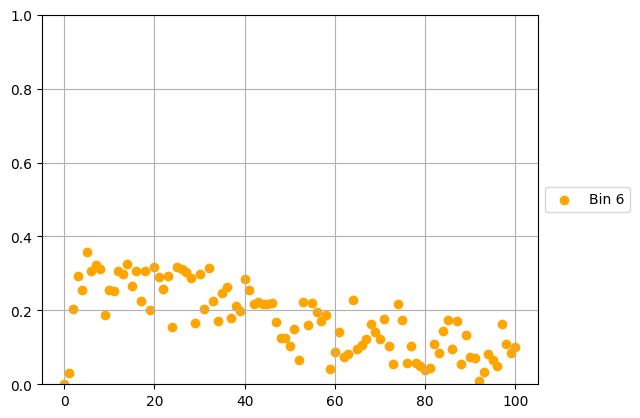

In [24]:
# Plotting median prediction from a sing output bin in the model for each distance

plt.scatter(distances, medians[:, 5], color='orange', label='Bin 6')
plt.ylim(0, 1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.savefig('0to100MB_Bin6.png', bbox_inches='tight')

In [25]:
# Generating interchromsomal examples

predictions = np.zeros([100, len(labels)])
hic = hicstraw.HiCFile(files[0])
expected_matrix = get_expected_matrix(hic, res, WIDTH)
thresholds = get_med_threshold(hic, [95, 90, 80], res, WIDTH)

for j in range(100):
  observed, _, __ = data_interchromosomal(hic = hic, size = WIDTH, res = res, ds_scale=10)
  input_matrix = np.zeros([1, WIDTH, WIDTH, 9])
  input_matrix[0, :, :, 0] = globalPercentileProcess(observed, thresholds[0]) # Preprocessing
  input_matrix[0, :, :, 1] = globalPercentileProcess(observed, thresholds[1])
  input_matrix[0, :, :, 2] = globalPercentileProcess(observed, thresholds[2])
  input_matrix[:, :, :, 3:6] = input_matrix[:, :, :, :3]
  clear_diagonal(input_matrix[:, :, :, 3:6]) # Clearing the middle diagonal of the matrix
  input_matrix[:, :, :, 6:] = blur(input_matrix[:, :, :, :3], gauss_kernel, kernel_size) # Blurring the matrix
  predictions[j] = model.predict(input_matrix)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


<ipython-input-9-a19cc802ad99>:38: RuntimeWarning: invalid value encountered in divide
  matrix = matrix_observed/matrix_oe


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

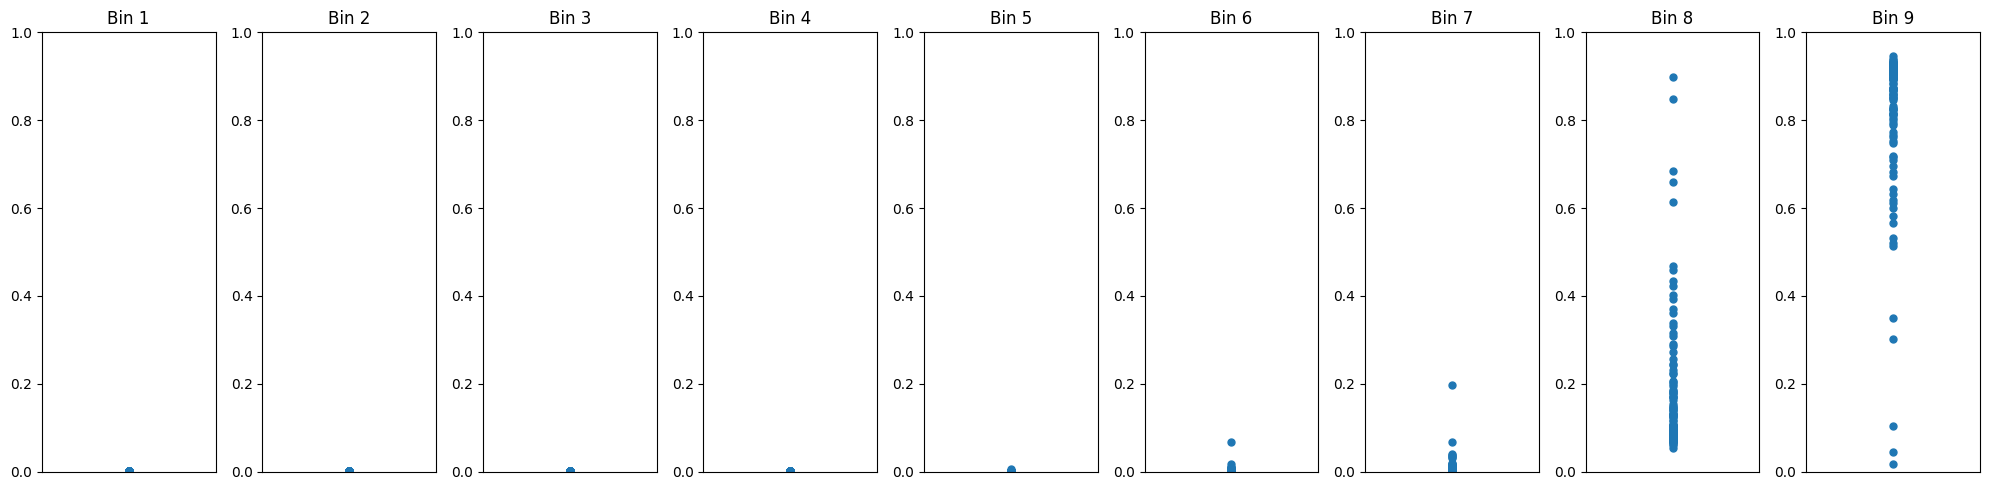

In [26]:
# Plotting boxplot of values from each output bin for interchromosomal examples

fig, axes = plt.subplots(1, 9, figsize=(20, 5)) # Adjust figsize as needed

# Iterate through datasets and create each subplot
for i, ax in enumerate(axes):
    ax.plot(np.zeros_like(predictions[:, i]), predictions[:, i], 'o', markersize=5)
    ax.set_title(f"Bin {i+1}")
    ax.set_ylim(0, 1)  # Ensure y-axis is from 0 to 1
    ax.get_xaxis().set_visible(False)  # Hide the x-axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.savefig('Interchromosomal_BinsAll.png', bbox_inches='tight')

Saliency maps

In [27]:
!pip install saliency
import saliency
from tensorflow.keras import backend as K
from tensorflow.keras.activations import linear

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 1.1 MB/s eta 0:00:00


In [29]:
# Examples with the following distances (in MB) for breaks will be generated to get saliency maps
# 5 distances for each bin
distances = [[0, 0.05, 0.1, 0.15, 0.2],
             [0.25, 0.3, 0.35, 0.4, 0.45],
             [0.5, 0.6, 0.7, 0.8, 0.9],
             [1, 1.2, 1.4, 1.6, 1.8],
             [2.5, 3, 3.5, 4, 4.5],
             [5, 6, 7, 8, 9]]

layer = model.layers[-1]  # For example, change the second layer

# Set the activation of the layer
layer.activation = linear

# Rebuild model (necessary because we've updated the activation function)
# You may need to save and load the model to properly rebuild it
model.save('temporary_model.h5')
model = tf.keras.models.load_model('temporary_model.h5')
# categorical_crossentropy for loss function
# Recompile the model if necessary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

def get_saliency_map(model, image, class_idx):
    # Ensure the input image tensor has the correct shape

    with tf.GradientTape() as tape:
        # Add a batch dimension to the image tensor
        image_expanded = tf.expand_dims(image, axis=0)
        tape.watch(image_expanded)
        predictions = model(image_expanded)

        # Extract the probability of the target class from model predictions
        target_class_probs = predictions[:, class_idx]

    # Compute the gradients of the target class probability w.r.t. the input image
    gradient = tape.gradient(target_class_probs, image_expanded)

    # Squeeze the batch dimension from the gradient tensor
    saliency_map = tf.squeeze(gradient, axis=0)

    return saliency_map

<ipython-input-9-a19cc802ad99>:38: RuntimeWarning: invalid value encountered in divide
  matrix = matrix_observed/matrix_oe


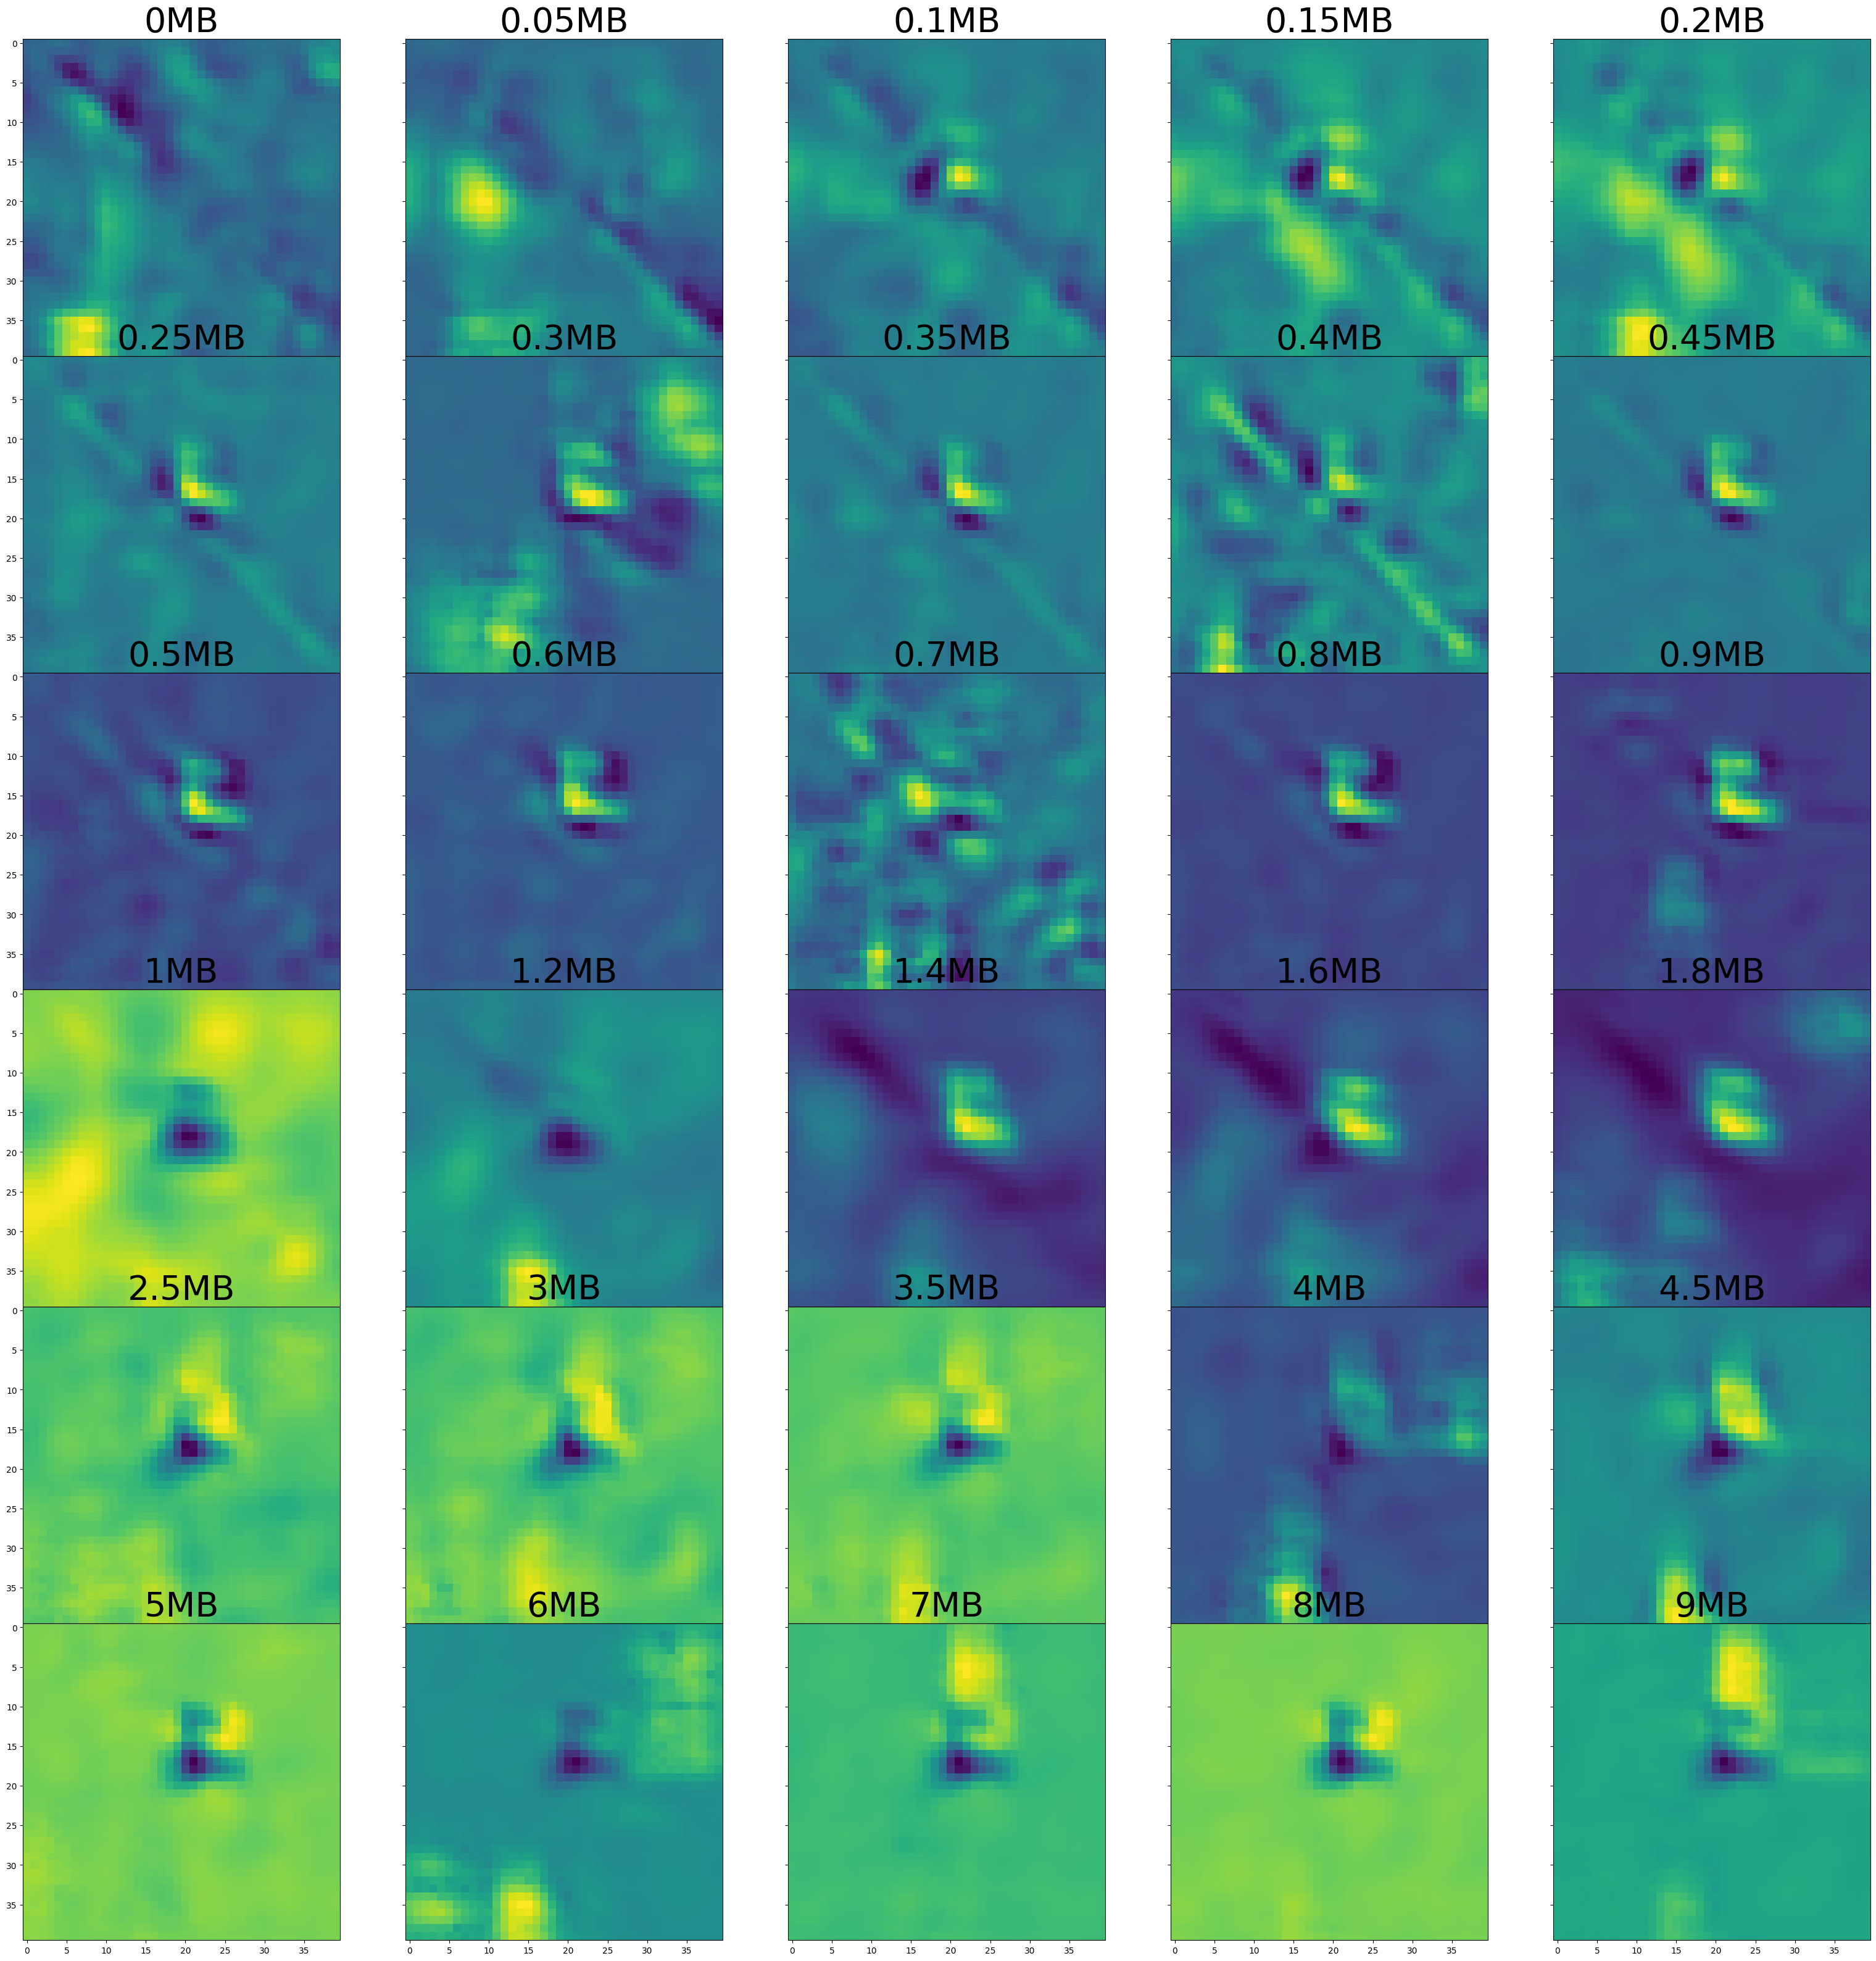

In [33]:
thresholds = get_med_threshold(hic, [95, 90, 80], res, WIDTH) # Centile thresholds
hic = hicstraw.HiCFile(files[0])
expected_matrix = get_expected_matrix(hic, res, WIDTH) # Manually generating expected matrix

c = 1000*1000 # Constant to multiply with

fig, axs = plt.subplots(6, 5, figsize=(40, 40), sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

for i in range(6):
  for j in range(5):
    distance = distances[i][j]
    observed, _, __ = data_specific_distance_intrachromosomal(hic = hic, size = WIDTH, res = res, ds_scale=10, distance=int(distance*c)) # Getting example
    input_matrix = np.zeros([1, WIDTH, WIDTH, 9])
    input_matrix[0, :, :, 0] = globalPercentileProcess(observed, thresholds[0]) # Preprocessing
    input_matrix[0, :, :, 1] = globalPercentileProcess(observed, thresholds[1])
    input_matrix[0, :, :, 2] = globalPercentileProcess(observed, thresholds[2])
    input_matrix[:, :, :, 3:6] = input_matrix[:, :, :, :3]
    clear_diagonal(input_matrix[:, :, :, 3:6]) # Clearing the middle diagonal of the matrix
    input_matrix[:, :, :, 6:] = blur(input_matrix[:, :, :, :3], gauss_kernel, kernel_size) # Blurring the matrix
    saliency_map = get_saliency_map(model, input_matrix[0], i) # Generating saliency map
    axs[i, j].imshow(saliency_map[:, :, i])
    axs[i, j].set_title(str(distance) + "MB", fontsize=40)

plt.savefig("DistanceVsSaliency.png")